In [69]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from google.colab import drive
import os
!pip install scikeras
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from math import sqrt


In [25]:
#Mount Google drive
drive.mount('/content/drive')

#Adjust your working directory
os.chdir('/content/drive/My Drive/Data_Projects/MDS/3rd semester/Deep learning LAB/Assignments/LSTM-time-series-tutorial')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
# Change to your file path
file_path = 'data/df_daily.csv'

#df_ori = pd.read_csv(file_path, index_col=['datetime'])
df_ori = pd.read_csv(file_path)

# Split into df_30_days_future and df_ori
df_30_days_future = df_ori.tail(30)
df_ori = df_ori.iloc[:-30]

# Export the two datasets
df_30_days_future.to_csv('data/df_daily_future_test.csv', index=False)
df_ori.to_csv('data/df_daily_train_valid.csv', index=False)

# set the index
df_ori = df_ori.set_index('datetime')
df_30_days_future = df_30_days_future.set_index('datetime')

# Delete the last 30 results to predict it using the odel in the future
df_30_days_future['total_real_power'] = np.nan


In [115]:
df = df_ori.copy()
df.head()

,total_real_power,reactive_power,voltage,current_intensity,kitchen,laundry_room,temp_control
datetime,,,,,,,
2006-12-16,1209.176,34.922,236.24376,5180.8,0.00,32.760002,295.56
2006-12-17,3390.460,226.006,240.08702,14398.6,121.98,251.220000,800.46
2006-12-18,2203.826,161.792,241.23169,9247.2,63.78,157.260000,841.08
2006-12-19,1666.194,150.942,241.99930,7094.0,50.34,456.120000,371.82
2006-12-20,2225.748,160.998,242.30807,9313.0,0.00,158.880000,843.78


In [28]:
# Fill missing values with the value from previous observation

# define a function topy previous value and fill in the missing observation
def fill_missing(values):
    one_day = 60*24
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            if np.isnan(values[row][col]):
                values[row,col] = values[row-one_day,col]

#convert to float
df = df.astype('float32')

# Call function
fill_missing(df.values)

# Check Na values
df.isnull().sum()


total_real_power     0
reactive_power       0
voltage              0
current_intensity    0
kitchen              0
laundry_room         0
temp_control         0
dtype: int64

In [29]:
#Split the dataframe into train and validation sets
test_split=round(len(df)*0.20)

df_for_training = df[:-test_split]
df_for_testing = df[-test_split:]

In [30]:
print(df_for_training.shape)
print(df_for_testing.shape)

(1130, 7)
(282, 7)


In [31]:
df_for_testing.tail()

,total_real_power,reactive_power,voltage,current_intensity,kitchen,laundry_room,temp_control
datetime,,,,,,,
2010-10-23,2293.236084,213.112000,242.243530,9633.200195,224.220001,232.979996,807.900024
2010-10-24,2392.461914,269.612000,243.022568,10039.000000,119.040001,452.579987,795.359985
2010-10-25,1163.291992,159.328003,242.406158,4884.799805,0.000000,32.459999,404.880005
2010-10-26,945.903992,173.266006,244.890945,3960.600098,0.000000,149.279999,299.339996
2010-10-27,1260.277954,153.832001,246.108704,5217.000000,0.000000,123.479996,496.139984


In [32]:
# Let´s scale the dfs
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)

In [33]:
# Converting the series to samples

def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)


trainX,trainY=createXY(df_for_training_scaled,30)
testX,testY=createXY(df_for_testing_scaled,30)


In [34]:
trainX.shape

(1100, 30, 7)

In [35]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (1100, 30, 7)
trainY Shape--  (1100,)


In [36]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

testX Shape--  (252, 30, 7)
testY Shape--  (252,)


In [37]:
#Let´s evaluate the parameters

def build_model(optimizer =  'adam'):
    grid_model = Sequential()
    grid_model.add(LSTM(100,return_sequences=True,input_shape=(30,7)))
    grid_model.add(LSTM(100))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1)
parameters = {'batch_size' : [16, 32, 64, 72],
              'epochs' : [15, 20, 25, 30],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

In [38]:
# Evaluate with grid!
grid_search = grid_search.fit(trainX, trainY)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
35/35 [==============================] - 5s 9ms/step - loss: 0.0171
Epoch 2/15
35/35 [==============================] - 0s 8ms/step - loss: 0.0091
Epoch 3/15
35/35 [==============================] - 0s 9ms/step - loss: 0.0085
Epoch 4/15
35/35 [==============================] - 0s 9ms/step - loss: 0.0091
Epoch 5/15
35/35 [==============================] - 0s 8ms/step - loss: 0.0093
Epoch 6/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0094
Epoch 7/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 8/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0087
Epoch 9/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0085
Epoch 10/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0082
Epoch 11/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0095
Epoch 12/15
35/35 [==============================] - 0s 6ms/step - loss: 0.0092
Epoch 13/15
35/35 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
35/35 [==============================] - 3s 8ms/step - loss: 0.0231
Epoch 2/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0152
Epoch 3/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0135
Epoch 4/15
35/35 [==============================] - 0s 6ms/step - loss: 0.0141
Epoch 5/15
35/35 [==============================] - 0s 6ms/step - loss: 0.0134
Epoch 6/15
35/35 [==============================] - 0s 6ms/step - loss: 0.0126
Epoch 7/15
35/35 [==============================] - 0s 6ms/step - loss: 0.0137
Epoch 8/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0121
Epoch 9/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0130
Epoch 10/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0126
Epoch 11/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0126
Epoch 12/15
35/35 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 13/15
35/35 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
35/35 [==============================] - 4s 8ms/step - loss: 0.0126
Epoch 2/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0093
Epoch 3/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0091
Epoch 4/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0092
Epoch 5/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0090
Epoch 6/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0097
Epoch 7/15
35/35 [==============================] - 0s 6ms/step - loss: 0.0096
Epoch 8/15
35/35 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 9/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 10/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 11/15
35/35 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 12/15
35/35 [==============================] - 0s 8ms/step - loss: 0.0085
Epoch 13/15
35/35 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
35/35 [==============================] - 4s 9ms/step - loss: 0.0205
Epoch 2/15
35/35 [==============================] - 0s 9ms/step - loss: 0.0144
Epoch 3/15
35/35 [==============================] - 0s 9ms/step - loss: 0.0134
Epoch 4/15
35/35 [==============================] - 0s 9ms/step - loss: 0.0131
Epoch 5/15
35/35 [==============================] - 0s 8ms/step - loss: 0.0126
Epoch 6/15
35/35 [==============================] - 0s 9ms/step - loss: 0.0132
Epoch 7/15
35/35 [==============================] - 0s 9ms/step - loss: 0.0134
Epoch 8/15
35/35 [==============================] - 0s 9ms/step - loss: 0.0129
Epoch 9/15
35/35 [==============================] - 0s 9ms/step - loss: 0.0130
Epoch 10/15
35/35 [==============================] - 0s 8ms/step - loss: 0.0125
Epoch 11/15
35/35 [==============================] - 0s 9ms/step - loss: 0.0126
Epoch 12/15
35/35 [==============================] - 0s 8ms/step - loss: 0.0122
Epoch 13/15
35/35 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
35/35 [==============================] - 4s 10ms/step - loss: 0.0161
Epoch 2/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0097
Epoch 3/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0089
Epoch 4/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0088
Epoch 5/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0090
Epoch 6/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0094
Epoch 7/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0089
Epoch 8/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0094
Epoch 9/20
35/35 [==============================] - 0s 8ms/step - loss: 0.0083
Epoch 10/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0081
Epoch 11/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0087
Epoch 12/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0086
Epoch 13/20
35/35 [=============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
35/35 [==============================] - 6s 9ms/step - loss: 0.0211
Epoch 2/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0149
Epoch 3/20
35/35 [==============================] - 0s 10ms/step - loss: 0.0139
Epoch 4/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0137
Epoch 5/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0134
Epoch 6/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0127
Epoch 7/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 8/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0132
Epoch 9/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 10/20
35/35 [==============================] - 0s 10ms/step - loss: 0.0129
Epoch 11/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0126
Epoch 12/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0122
Epoch 13/20
35/35 [============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
35/35 [==============================] - 4s 8ms/step - loss: 0.0137
Epoch 2/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0092
Epoch 3/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0097
Epoch 4/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 5/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0091
Epoch 6/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 7/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0096
Epoch 8/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 9/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 10/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 11/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0093
Epoch 12/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 13/20
35/35 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
35/35 [==============================] - 3s 8ms/step - loss: 0.0268
Epoch 2/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0136
Epoch 3/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0136
Epoch 4/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0133
Epoch 5/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0121
Epoch 6/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0132
Epoch 7/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 8/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 9/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 10/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0127
Epoch 11/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0127
Epoch 12/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 13/20
35/35 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
35/35 [==============================] - 4s 8ms/step - loss: 0.0223
Epoch 2/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0098
Epoch 3/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 4/25
35/35 [==============================] - 0s 7ms/step - loss: 0.0091
Epoch 5/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 6/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0097
Epoch 7/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 8/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0085
Epoch 9/25
35/35 [==============================] - 0s 7ms/step - loss: 0.0091
Epoch 10/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 11/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 12/25
35/35 [==============================] - 0s 7ms/step - loss: 0.0082
Epoch 13/25
35/35 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
35/35 [==============================] - 5s 9ms/step - loss: 0.0209
Epoch 2/25
35/35 [==============================] - 0s 9ms/step - loss: 0.0139
Epoch 3/25
35/35 [==============================] - 0s 10ms/step - loss: 0.0139
Epoch 4/25
35/35 [==============================] - 0s 9ms/step - loss: 0.0127
Epoch 5/25
35/35 [==============================] - 0s 8ms/step - loss: 0.0134
Epoch 6/25
35/35 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 7/25
35/35 [==============================] - 0s 10ms/step - loss: 0.0128
Epoch 8/25
35/35 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 9/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0127
Epoch 10/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0124
Epoch 11/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0124
Epoch 12/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0126
Epoch 13/25
35/35 [============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
35/35 [==============================] - 3s 8ms/step - loss: 0.0169
Epoch 2/25
35/35 [==============================] - 0s 7ms/step - loss: 0.0091
Epoch 3/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 4/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 5/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 6/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0086
Epoch 7/25
35/35 [==============================] - 0s 7ms/step - loss: 0.0099
Epoch 8/25
35/35 [==============================] - 0s 9ms/step - loss: 0.0089
Epoch 9/25
35/35 [==============================] - 0s 9ms/step - loss: 0.0088
Epoch 10/25
35/35 [==============================] - 0s 9ms/step - loss: 0.0087
Epoch 11/25
35/35 [==============================] - 0s 9ms/step - loss: 0.0083
Epoch 12/25
35/35 [==============================] - 0s 9ms/step - loss: 0.0083
Epoch 13/25
35/35 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
35/35 [==============================] - 3s 8ms/step - loss: 0.0256
Epoch 2/25
35/35 [==============================] - 0s 7ms/step - loss: 0.0135
Epoch 3/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0141
Epoch 4/25
35/35 [==============================] - 0s 7ms/step - loss: 0.0129
Epoch 5/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0130
Epoch 6/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0127
Epoch 7/25
35/35 [==============================] - 0s 7ms/step - loss: 0.0127
Epoch 8/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0126
Epoch 9/25
35/35 [==============================] - 0s 7ms/step - loss: 0.0121
Epoch 10/25
35/35 [==============================] - 0s 6ms/step - loss: 0.0121
Epoch 11/25
35/35 [==============================] - 0s 7ms/step - loss: 0.0118
Epoch 12/25
35/35 [==============================] - 0s 7ms/step - loss: 0.0130
Epoch 13/25
35/35 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
35/35 [==============================] - 4s 8ms/step - loss: 0.0190
Epoch 2/30
35/35 [==============================] - 0s 7ms/step - loss: 0.0096
Epoch 3/30
35/35 [==============================] - 0s 7ms/step - loss: 0.0091
Epoch 4/30
35/35 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 5/30
35/35 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 6/30
35/35 [==============================] - 0s 7ms/step - loss: 0.0087
Epoch 7/30
35/35 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 8/30
35/35 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 9/30
35/35 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 10/30
35/35 [==============================] - 0s 7ms/step - loss: 0.0087
Epoch 11/30
35/35 [==============================] - 0s 7ms/step - loss: 0.0085
Epoch 12/30
35/35 [==============================] - 0s 9ms/step - loss: 0.0084
Epoch 13/30
35/35 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
35/35 [==============================] - 5s 8ms/step - loss: 0.0215
Epoch 2/30
35/35 [==============================] - 0s 7ms/step - loss: 0.0135
Epoch 3/30
35/35 [==============================] - 0s 7ms/step - loss: 0.0136
Epoch 4/30
35/35 [==============================] - 0s 7ms/step - loss: 0.0137
Epoch 5/30
35/35 [==============================] - 0s 6ms/step - loss: 0.0139
Epoch 6/30
35/35 [==============================] - 0s 7ms/step - loss: 0.0124
Epoch 7/30
35/35 [==============================] - 0s 7ms/step - loss: 0.0132
Epoch 8/30
35/35 [==============================] - 0s 6ms/step - loss: 0.0128
Epoch 9/30
35/35 [==============================] - 0s 6ms/step - loss: 0.0132
Epoch 10/30
35/35 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 11/30
35/35 [==============================] - 0s 7ms/step - loss: 0.0124
Epoch 12/30
35/35 [==============================] - 0s 6ms/step - loss: 0.0126
Epoch 13/30
35/35 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
35/35 [==============================] - 5s 10ms/step - loss: 0.0163
Epoch 2/30
35/35 [==============================] - 0s 8ms/step - loss: 0.0109
Epoch 3/30
35/35 [==============================] - 0s 9ms/step - loss: 0.0101
Epoch 4/30
35/35 [==============================] - 0s 9ms/step - loss: 0.0086
Epoch 5/30
35/35 [==============================] - 0s 8ms/step - loss: 0.0092
Epoch 6/30
35/35 [==============================] - 0s 8ms/step - loss: 0.0088
Epoch 7/30
35/35 [==============================] - 0s 9ms/step - loss: 0.0090
Epoch 8/30
35/35 [==============================] - 0s 9ms/step - loss: 0.0088
Epoch 9/30
35/35 [==============================] - 0s 7ms/step - loss: 0.0098
Epoch 10/30
35/35 [==============================] - 0s 6ms/step - loss: 0.0085
Epoch 11/30
35/35 [==============================] - 0s 7ms/step - loss: 0.0083
Epoch 12/30
35/35 [==============================] - 0s 7ms/step - loss: 0.0083
Epoch 13/30
35/35 [=============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
35/35 [==============================] - 3s 8ms/step - loss: 0.0215
Epoch 2/30
35/35 [==============================] - 0s 7ms/step - loss: 0.0144
Epoch 3/30
35/35 [==============================] - 0s 9ms/step - loss: 0.0133
Epoch 4/30
35/35 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 5/30
35/35 [==============================] - 0s 9ms/step - loss: 0.0131
Epoch 6/30
35/35 [==============================] - 0s 9ms/step - loss: 0.0145
Epoch 7/30
35/35 [==============================] - 0s 9ms/step - loss: 0.0132
Epoch 8/30
35/35 [==============================] - 0s 9ms/step - loss: 0.0141
Epoch 9/30
35/35 [==============================] - 0s 9ms/step - loss: 0.0125
Epoch 10/30
35/35 [==============================] - 0s 9ms/step - loss: 0.0127
Epoch 11/30
35/35 [==============================] - 0s 9ms/step - loss: 0.0123
Epoch 12/30
35/35 [==============================] - 0s 9ms/step - loss: 0.0120
Epoch 13/30
35/35 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
18/18 [==============================] - 3s 8ms/step - loss: 0.0188
Epoch 2/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0099
Epoch 3/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0093
Epoch 4/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0098
Epoch 5/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0093
Epoch 6/15
18/18 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 7/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0085
Epoch 8/15
18/18 [==============================] - 0s 6ms/step - loss: 0.0086
Epoch 9/15
18/18 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 10/15
18/18 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 11/15
18/18 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 12/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0083
Epoch 13/15
18/18 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
18/18 [==============================] - 5s 10ms/step - loss: 0.0275
Epoch 2/15
18/18 [==============================] - 0s 9ms/step - loss: 0.0139
Epoch 3/15
18/18 [==============================] - 0s 9ms/step - loss: 0.0135
Epoch 4/15
18/18 [==============================] - 0s 9ms/step - loss: 0.0123
Epoch 5/15
18/18 [==============================] - 0s 9ms/step - loss: 0.0144
Epoch 6/15
18/18 [==============================] - 0s 9ms/step - loss: 0.0129
Epoch 7/15
18/18 [==============================] - 0s 8ms/step - loss: 0.0126
Epoch 8/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0131
Epoch 9/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0132
Epoch 10/15
18/18 [==============================] - 0s 6ms/step - loss: 0.0127
Epoch 11/15
18/18 [==============================] - 0s 6ms/step - loss: 0.0120
Epoch 12/15
18/18 [==============================] - 0s 6ms/step - loss: 0.0127
Epoch 13/15
18/18 [=============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
18/18 [==============================] - 3s 8ms/step - loss: 0.0249
Epoch 2/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0100
Epoch 3/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0093
Epoch 4/15
18/18 [==============================] - 0s 6ms/step - loss: 0.0094
Epoch 5/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0095
Epoch 6/15
18/18 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 7/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 8/15
18/18 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 9/15
18/18 [==============================] - 0s 6ms/step - loss: 0.0086
Epoch 10/15
18/18 [==============================] - 0s 6ms/step - loss: 0.0086
Epoch 11/15
18/18 [==============================] - 0s 6ms/step - loss: 0.0085
Epoch 12/15
18/18 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 13/15
18/18 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
18/18 [==============================] - 7s 8ms/step - loss: 0.0320
Epoch 2/15
18/18 [==============================] - 0s 8ms/step - loss: 0.0137
Epoch 3/15
18/18 [==============================] - 0s 8ms/step - loss: 0.0139
Epoch 4/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0132
Epoch 5/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0131
Epoch 6/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0133
Epoch 7/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0126
Epoch 8/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 9/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0124
Epoch 10/15
18/18 [==============================] - 0s 6ms/step - loss: 0.0130
Epoch 11/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 12/15
18/18 [==============================] - 0s 7ms/step - loss: 0.0126
Epoch 13/15
18/18 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
18/18 [==============================] - 3s 8ms/step - loss: 0.0273
Epoch 2/20
18/18 [==============================] - 0s 8ms/step - loss: 0.0102
Epoch 3/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0094
Epoch 4/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 5/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0090
Epoch 6/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0084
Epoch 7/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 8/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0084
Epoch 9/20
18/18 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 10/20
18/18 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 11/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 12/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 13/20
18/18 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
18/18 [==============================] - 4s 8ms/step - loss: 0.0373
Epoch 2/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0153
Epoch 3/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0139
Epoch 4/20
18/18 [==============================] - 0s 6ms/step - loss: 0.0136
Epoch 5/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0131
Epoch 6/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0131
Epoch 7/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0132
Epoch 8/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0127
Epoch 9/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0130
Epoch 10/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0131
Epoch 11/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0124
Epoch 12/20
18/18 [==============================] - 0s 6ms/step - loss: 0.0123
Epoch 13/20
18/18 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
18/18 [==============================] - 3s 8ms/step - loss: 0.0209
Epoch 2/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0100
Epoch 3/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0093
Epoch 4/20
18/18 [==============================] - 0s 9ms/step - loss: 0.0089
Epoch 5/20
18/18 [==============================] - 0s 10ms/step - loss: 0.0085
Epoch 6/20
18/18 [==============================] - 0s 9ms/step - loss: 0.0084
Epoch 7/20
18/18 [==============================] - 0s 9ms/step - loss: 0.0086
Epoch 8/20
18/18 [==============================] - 0s 9ms/step - loss: 0.0087
Epoch 9/20
18/18 [==============================] - 0s 9ms/step - loss: 0.0085
Epoch 10/20
18/18 [==============================] - 0s 8ms/step - loss: 0.0089
Epoch 11/20
18/18 [==============================] - 0s 8ms/step - loss: 0.0092
Epoch 12/20
18/18 [==============================] - 0s 9ms/step - loss: 0.0082
Epoch 13/20
18/18 [=============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
18/18 [==============================] - 4s 8ms/step - loss: 0.0297
Epoch 2/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0153
Epoch 3/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0135
Epoch 4/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0141
Epoch 5/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0138
Epoch 6/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0130
Epoch 7/20
18/18 [==============================] - 0s 6ms/step - loss: 0.0131
Epoch 8/20
18/18 [==============================] - 0s 6ms/step - loss: 0.0126
Epoch 9/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0133
Epoch 10/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0122
Epoch 11/20
18/18 [==============================] - 0s 7ms/step - loss: 0.0124
Epoch 12/20
18/18 [==============================] - 0s 6ms/step - loss: 0.0126
Epoch 13/20
18/18 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
18/18 [==============================] - 4s 10ms/step - loss: 0.0248
Epoch 2/25
18/18 [==============================] - 0s 9ms/step - loss: 0.0125
Epoch 3/25
18/18 [==============================] - 0s 9ms/step - loss: 0.0099
Epoch 4/25
18/18 [==============================] - 0s 8ms/step - loss: 0.0093
Epoch 5/25
18/18 [==============================] - 0s 8ms/step - loss: 0.0087
Epoch 6/25
18/18 [==============================] - 0s 8ms/step - loss: 0.0085
Epoch 7/25
18/18 [==============================] - 0s 9ms/step - loss: 0.0086
Epoch 8/25
18/18 [==============================] - 0s 8ms/step - loss: 0.0090
Epoch 9/25
18/18 [==============================] - 0s 9ms/step - loss: 0.0086
Epoch 10/25
18/18 [==============================] - 0s 8ms/step - loss: 0.0085
Epoch 11/25
18/18 [==============================] - 0s 8ms/step - loss: 0.0084
Epoch 12/25
18/18 [==============================] - 0s 9ms/step - loss: 0.0086
Epoch 13/25
18/18 [=============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
18/18 [==============================] - 3s 8ms/step - loss: 0.0289
Epoch 2/25
18/18 [==============================] - 0s 8ms/step - loss: 0.0149
Epoch 3/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0139
Epoch 4/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0133
Epoch 5/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0135
Epoch 6/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0131
Epoch 7/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0152
Epoch 8/25
18/18 [==============================] - 0s 6ms/step - loss: 0.0134
Epoch 9/25
18/18 [==============================] - 0s 6ms/step - loss: 0.0128
Epoch 10/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0122
Epoch 11/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0130
Epoch 12/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0129
Epoch 13/25
18/18 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
18/18 [==============================] - 5s 10ms/step - loss: 0.0191
Epoch 2/25
18/18 [==============================] - 0s 9ms/step - loss: 0.0100
Epoch 3/25
18/18 [==============================] - 0s 9ms/step - loss: 0.0085
Epoch 4/25
18/18 [==============================] - 0s 9ms/step - loss: 0.0090
Epoch 5/25
18/18 [==============================] - 0s 9ms/step - loss: 0.0094
Epoch 6/25
18/18 [==============================] - 0s 8ms/step - loss: 0.0094
Epoch 7/25
18/18 [==============================] - 0s 9ms/step - loss: 0.0087
Epoch 8/25
18/18 [==============================] - 0s 8ms/step - loss: 0.0086
Epoch 9/25
18/18 [==============================] - 0s 9ms/step - loss: 0.0086
Epoch 10/25
18/18 [==============================] - 0s 9ms/step - loss: 0.0090
Epoch 11/25
18/18 [==============================] - 0s 9ms/step - loss: 0.0093
Epoch 12/25
18/18 [==============================] - 0s 9ms/step - loss: 0.0085
Epoch 13/25
18/18 [=============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
18/18 [==============================] - 3s 8ms/step - loss: 0.0265
Epoch 2/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0171
Epoch 3/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0137
Epoch 4/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0131
Epoch 5/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0135
Epoch 6/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 7/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0142
Epoch 8/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0129
Epoch 9/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0126
Epoch 10/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0127
Epoch 11/25
18/18 [==============================] - 0s 6ms/step - loss: 0.0123
Epoch 12/25
18/18 [==============================] - 0s 7ms/step - loss: 0.0130
Epoch 13/25
18/18 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
18/18 [==============================] - 5s 11ms/step - loss: 0.0358
Epoch 2/30
18/18 [==============================] - 0s 9ms/step - loss: 0.0113
Epoch 3/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0094
Epoch 4/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0092
Epoch 5/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0085
Epoch 6/30
18/18 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 7/30
18/18 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 8/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0090
Epoch 9/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0087
Epoch 10/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0083
Epoch 11/30
18/18 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 12/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0087
Epoch 13/30
18/18 [=============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
18/18 [==============================] - 3s 8ms/step - loss: 0.0252
Epoch 2/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0152
Epoch 3/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0138
Epoch 4/30
18/18 [==============================] - 0s 6ms/step - loss: 0.0131
Epoch 5/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0129
Epoch 6/30
18/18 [==============================] - 0s 6ms/step - loss: 0.0132
Epoch 7/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0126
Epoch 8/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0128
Epoch 9/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0126
Epoch 10/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0121
Epoch 11/30
18/18 [==============================] - 0s 6ms/step - loss: 0.0130
Epoch 12/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0130
Epoch 13/30
18/18 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
18/18 [==============================] - 4s 8ms/step - loss: 0.0179
Epoch 2/30
18/18 [==============================] - 0s 8ms/step - loss: 0.0102
Epoch 3/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0093
Epoch 4/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0093
Epoch 5/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0092
Epoch 6/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 7/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 8/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 9/30
18/18 [==============================] - 0s 6ms/step - loss: 0.0094
Epoch 10/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 11/30
18/18 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 12/30
18/18 [==============================] - 0s 7ms/step - loss: 0.0084
Epoch 13/30
18/18 [==============================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
18/18 [==============================] - 4s 9ms/step - loss: 0.0300
Epoch 2/30
18/18 [==============================] - 0s 9ms/step - loss: 0.0145
Epoch 3/30
18/18 [==============================] - 0s 10ms/step - loss: 0.0144
Epoch 4/30
18/18 [==============================] - 0s 9ms/step - loss: 0.0129
Epoch 5/30
18/18 [==============================] - 0s 8ms/step - loss: 0.0138
Epoch 6/30
18/18 [==============================] - 0s 9ms/step - loss: 0.0141
Epoch 7/30
18/18 [==============================] - 0s 8ms/step - loss: 0.0129
Epoch 8/30
18/18 [==============================] - 0s 10ms/step - loss: 0.0126
Epoch 9/30
18/18 [==============================] - 0s 10ms/step - loss: 0.0127
Epoch 10/30
18/18 [==============================] - 0s 9ms/step - loss: 0.0133
Epoch 11/30
18/18 [==============================] - 0s 10ms/step - loss: 0.0123
Epoch 12/30
18/18 [==============================] - 0s 10ms/step - loss: 0.0128
Epoch 13/30
18/18 [=========================

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
9/9 [==============================] - 3s 9ms/step - loss: 0.0275
Epoch 2/15
9/9 [==============================] - 0s 9ms/step - loss: 0.0117
Epoch 3/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0106
Epoch 4/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0097
Epoch 5/15
9/9 [==============================] - 0s 7ms/step - loss: 0.0094
Epoch 6/15
9/9 [==============================] - 0s 7ms/step - loss: 0.0095
Epoch 7/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0089
Epoch 8/15
9/9 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 9/15
9/9 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 10/15
9/9 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 11/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0089
Epoch 12/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0088
Epoch 13/15
9/9 [==============================] - 0s 7ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
9/9 [==============================] - 3s 11ms/step - loss: 0.0569
Epoch 2/15
9/9 [==============================] - 0s 10ms/step - loss: 0.0207
Epoch 3/15
9/9 [==============================] - 0s 10ms/step - loss: 0.0157
Epoch 4/15
9/9 [==============================] - 0s 9ms/step - loss: 0.0146
Epoch 5/15
9/9 [==============================] - 0s 9ms/step - loss: 0.0135
Epoch 6/15
9/9 [==============================] - 0s 9ms/step - loss: 0.0129
Epoch 7/15
9/9 [==============================] - 0s 9ms/step - loss: 0.0132
Epoch 8/15
9/9 [==============================] - 0s 9ms/step - loss: 0.0130
Epoch 9/15
9/9 [==============================] - 0s 9ms/step - loss: 0.0126
Epoch 10/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0125
Epoch 11/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0127
Epoch 12/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0128
Epoch 13/15
9/9 [==============================] - 0s 9ms/step - loss:

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
9/9 [==============================] - 4s 9ms/step - loss: 0.0354
Epoch 2/15
9/9 [==============================] - 0s 9ms/step - loss: 0.0148
Epoch 3/15
9/9 [==============================] - 0s 9ms/step - loss: 0.0117
Epoch 4/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0102
Epoch 5/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0104
Epoch 6/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0096
Epoch 7/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0091
Epoch 8/15
9/9 [==============================] - 0s 7ms/step - loss: 0.0090
Epoch 9/15
9/9 [==============================] - 0s 7ms/step - loss: 0.0090
Epoch 10/15
9/9 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 11/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0085
Epoch 12/15
9/9 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 13/15
9/9 [==============================] - 0s 7ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
9/9 [==============================] - 3s 9ms/step - loss: 0.0434
Epoch 2/15
9/9 [==============================] - 0s 9ms/step - loss: 0.0198
Epoch 3/15
9/9 [==============================] - 0s 9ms/step - loss: 0.0162
Epoch 4/15
9/9 [==============================] - 0s 9ms/step - loss: 0.0142
Epoch 5/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0139
Epoch 6/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 7/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0131
Epoch 8/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0130
Epoch 9/15
9/9 [==============================] - 0s 7ms/step - loss: 0.0132
Epoch 10/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0133
Epoch 11/15
9/9 [==============================] - 0s 8ms/step - loss: 0.0124
Epoch 12/15
9/9 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 13/15
9/9 [==============================] - 0s 7ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
9/9 [==============================] - 4s 9ms/step - loss: 0.0176
Epoch 2/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0102
Epoch 3/20
9/9 [==============================] - 0s 10ms/step - loss: 0.0090
Epoch 4/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0091
Epoch 5/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0090
Epoch 6/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0090
Epoch 7/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0094
Epoch 8/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0085
Epoch 9/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0082
Epoch 10/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0083
Epoch 11/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 12/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0086
Epoch 13/20
9/9 [==============================] - 0s 8ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
9/9 [==============================] - 4s 10ms/step - loss: 0.0366
Epoch 2/20
9/9 [==============================] - 0s 10ms/step - loss: 0.0194
Epoch 3/20
9/9 [==============================] - 0s 11ms/step - loss: 0.0154
Epoch 4/20
9/9 [==============================] - 0s 9ms/step - loss: 0.0135
Epoch 5/20
9/9 [==============================] - 0s 10ms/step - loss: 0.0137
Epoch 6/20
9/9 [==============================] - 0s 10ms/step - loss: 0.0129
Epoch 7/20
9/9 [==============================] - 0s 9ms/step - loss: 0.0129
Epoch 8/20
9/9 [==============================] - 0s 9ms/step - loss: 0.0129
Epoch 9/20
9/9 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 10/20
9/9 [==============================] - 0s 10ms/step - loss: 0.0140
Epoch 11/20
9/9 [==============================] - 0s 9ms/step - loss: 0.0126
Epoch 12/20
9/9 [==============================] - 0s 10ms/step - loss: 0.0126
Epoch 13/20
9/9 [==============================] - 0s 9ms/step - l

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
9/9 [==============================] - 4s 9ms/step - loss: 0.0356
Epoch 2/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0142
Epoch 3/20
9/9 [==============================] - 0s 9ms/step - loss: 0.0103
Epoch 4/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0096
Epoch 5/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0093
Epoch 6/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0093
Epoch 7/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0087
Epoch 8/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0086
Epoch 9/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 10/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0090
Epoch 11/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0087
Epoch 12/20
9/9 [==============================] - 0s 9ms/step - loss: 0.0085
Epoch 13/20
9/9 [==============================] - 0s 7ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
9/9 [==============================] - 3s 9ms/step - loss: 0.0510
Epoch 2/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0197
Epoch 3/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0163
Epoch 4/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0149
Epoch 5/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0141
Epoch 6/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0137
Epoch 7/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0136
Epoch 8/20
9/9 [==============================] - 0s 9ms/step - loss: 0.0131
Epoch 9/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0131
Epoch 10/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0130
Epoch 11/20
9/9 [==============================] - 0s 7ms/step - loss: 0.0127
Epoch 12/20
9/9 [==============================] - 0s 8ms/step - loss: 0.0131
Epoch 13/20
9/9 [==============================] - 0s 10ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
9/9 [==============================] - 4s 9ms/step - loss: 0.0200
Epoch 2/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0101
Epoch 3/25
9/9 [==============================] - 0s 9ms/step - loss: 0.0105
Epoch 4/25
9/9 [==============================] - 0s 9ms/step - loss: 0.0094
Epoch 5/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0088
Epoch 6/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0086
Epoch 7/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0086
Epoch 8/25
9/9 [==============================] - 0s 7ms/step - loss: 0.0092
Epoch 9/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0088
Epoch 10/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0089
Epoch 11/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0086
Epoch 12/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0084
Epoch 13/25
9/9 [==============================] - 0s 7ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
9/9 [==============================] - 3s 9ms/step - loss: 0.0380
Epoch 2/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0189
Epoch 3/25
9/9 [==============================] - 0s 9ms/step - loss: 0.0172
Epoch 4/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0140
Epoch 5/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0141
Epoch 6/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0136
Epoch 7/25
9/9 [==============================] - 0s 7ms/step - loss: 0.0133
Epoch 8/25
9/9 [==============================] - 0s 7ms/step - loss: 0.0127
Epoch 9/25
9/9 [==============================] - 0s 7ms/step - loss: 0.0128
Epoch 10/25
9/9 [==============================] - 0s 7ms/step - loss: 0.0122
Epoch 11/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0125
Epoch 12/25
9/9 [==============================] - 0s 7ms/step - loss: 0.0127
Epoch 13/25
9/9 [==============================] - 0s 7ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
9/9 [==============================] - 5s 10ms/step - loss: 0.0284
Epoch 2/25
9/9 [==============================] - 0s 9ms/step - loss: 0.0121
Epoch 3/25
9/9 [==============================] - 0s 9ms/step - loss: 0.0098
Epoch 4/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0093
Epoch 5/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0090
Epoch 6/25
9/9 [==============================] - 0s 7ms/step - loss: 0.0092
Epoch 7/25
9/9 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 8/25
9/9 [==============================] - 0s 7ms/step - loss: 0.0087
Epoch 9/25
9/9 [==============================] - 0s 7ms/step - loss: 0.0085
Epoch 10/25
9/9 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 11/25
9/9 [==============================] - 0s 7ms/step - loss: 0.0090
Epoch 12/25
9/9 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 13/25
9/9 [==============================] - 0s 7ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
9/9 [==============================] - 3s 9ms/step - loss: 0.0472
Epoch 2/25
9/9 [==============================] - 0s 9ms/step - loss: 0.0181
Epoch 3/25
9/9 [==============================] - 0s 9ms/step - loss: 0.0145
Epoch 4/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 5/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0127
Epoch 6/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0129
Epoch 7/25
9/9 [==============================] - 0s 9ms/step - loss: 0.0130
Epoch 8/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0127
Epoch 9/25
9/9 [==============================] - 0s 7ms/step - loss: 0.0127
Epoch 10/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0131
Epoch 11/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0130
Epoch 12/25
9/9 [==============================] - 0s 8ms/step - loss: 0.0127
Epoch 13/25
9/9 [==============================] - 0s 8ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
9/9 [==============================] - 5s 10ms/step - loss: 0.0235
Epoch 2/30
9/9 [==============================] - 0s 10ms/step - loss: 0.0110
Epoch 3/30
9/9 [==============================] - 0s 12ms/step - loss: 0.0100
Epoch 4/30
9/9 [==============================] - 0s 9ms/step - loss: 0.0094
Epoch 5/30
9/9 [==============================] - 0s 9ms/step - loss: 0.0093
Epoch 6/30
9/9 [==============================] - 0s 9ms/step - loss: 0.0091
Epoch 7/30
9/9 [==============================] - 0s 9ms/step - loss: 0.0092
Epoch 8/30
9/9 [==============================] - 0s 10ms/step - loss: 0.0085
Epoch 9/30
9/9 [==============================] - 0s 10ms/step - loss: 0.0087
Epoch 10/30
9/9 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 11/30
9/9 [==============================] - 0s 10ms/step - loss: 0.0087
Epoch 12/30
9/9 [==============================] - 0s 10ms/step - loss: 0.0088
Epoch 13/30
9/9 [==============================] - 0s 9ms/step - 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
9/9 [==============================] - 3s 10ms/step - loss: 0.0360
Epoch 2/30
9/9 [==============================] - 0s 9ms/step - loss: 0.0170
Epoch 3/30
9/9 [==============================] - 0s 9ms/step - loss: 0.0145
Epoch 4/30
9/9 [==============================] - 0s 8ms/step - loss: 0.0143
Epoch 5/30
9/9 [==============================] - 0s 7ms/step - loss: 0.0132
Epoch 6/30
9/9 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 7/30
9/9 [==============================] - 0s 8ms/step - loss: 0.0129
Epoch 8/30
9/9 [==============================] - 0s 7ms/step - loss: 0.0127
Epoch 9/30
9/9 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 10/30
9/9 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 11/30
9/9 [==============================] - 0s 8ms/step - loss: 0.0129
Epoch 12/30
9/9 [==============================] - 0s 8ms/step - loss: 0.0127
Epoch 13/30
9/9 [==============================] - 0s 8ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
9/9 [==============================] - 4s 9ms/step - loss: 0.0472
Epoch 2/30
9/9 [==============================] - 0s 8ms/step - loss: 0.0161
Epoch 3/30
9/9 [==============================] - 0s 9ms/step - loss: 0.0112
Epoch 4/30
9/9 [==============================] - 0s 8ms/step - loss: 0.0100
Epoch 5/30
9/9 [==============================] - 0s 8ms/step - loss: 0.0088
Epoch 6/30
9/9 [==============================] - 0s 8ms/step - loss: 0.0090
Epoch 7/30
9/9 [==============================] - 0s 7ms/step - loss: 0.0090
Epoch 8/30
9/9 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 9/30
9/9 [==============================] - 0s 7ms/step - loss: 0.0091
Epoch 10/30
9/9 [==============================] - 0s 8ms/step - loss: 0.0087
Epoch 11/30
9/9 [==============================] - 0s 7ms/step - loss: 0.0087
Epoch 12/30
9/9 [==============================] - 0s 7ms/step - loss: 0.0087
Epoch 13/30
9/9 [==============================] - 0s 7ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
9/9 [==============================] - 3s 9ms/step - loss: 0.0449
Epoch 2/30
9/9 [==============================] - 0s 8ms/step - loss: 0.0202
Epoch 3/30
9/9 [==============================] - 0s 10ms/step - loss: 0.0154
Epoch 4/30
9/9 [==============================] - 0s 9ms/step - loss: 0.0141
Epoch 5/30
9/9 [==============================] - 0s 8ms/step - loss: 0.0134
Epoch 6/30
9/9 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 7/30
9/9 [==============================] - 0s 8ms/step - loss: 0.0130
Epoch 8/30
9/9 [==============================] - 0s 8ms/step - loss: 0.0132
Epoch 9/30
9/9 [==============================] - 0s 8ms/step - loss: 0.0129
Epoch 10/30
9/9 [==============================] - 0s 7ms/step - loss: 0.0132
Epoch 11/30
9/9 [==============================] - 0s 7ms/step - loss: 0.0128
Epoch 12/30
9/9 [==============================] - 0s 7ms/step - loss: 0.0130
Epoch 13/30
9/9 [==============================] - 0s 8ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
8/8 [==============================] - 5s 11ms/step - loss: 0.0380
Epoch 2/15
8/8 [==============================] - 0s 11ms/step - loss: 0.0153
Epoch 3/15
8/8 [==============================] - 0s 10ms/step - loss: 0.0115
Epoch 4/15
8/8 [==============================] - 0s 10ms/step - loss: 0.0095
Epoch 5/15
8/8 [==============================] - 0s 9ms/step - loss: 0.0094
Epoch 6/15
8/8 [==============================] - 0s 10ms/step - loss: 0.0089
Epoch 7/15
8/8 [==============================] - 0s 9ms/step - loss: 0.0085
Epoch 8/15
8/8 [==============================] - 0s 9ms/step - loss: 0.0084
Epoch 9/15
8/8 [==============================] - 0s 9ms/step - loss: 0.0090
Epoch 10/15
8/8 [==============================] - 0s 9ms/step - loss: 0.0090
Epoch 11/15
8/8 [==============================] - 0s 10ms/step - loss: 0.0090
Epoch 12/15
8/8 [==============================] - 0s 10ms/step - loss: 0.0083
Epoch 13/15
8/8 [==============================] - 0s 10ms/step - 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
8/8 [==============================] - 4s 9ms/step - loss: 0.0311
Epoch 2/15
8/8 [==============================] - 0s 9ms/step - loss: 0.0179
Epoch 3/15
8/8 [==============================] - 0s 9ms/step - loss: 0.0148
Epoch 4/15
8/8 [==============================] - 0s 9ms/step - loss: 0.0139
Epoch 5/15
8/8 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 6/15
8/8 [==============================] - 0s 8ms/step - loss: 0.0138
Epoch 7/15
8/8 [==============================] - 0s 8ms/step - loss: 0.0128
Epoch 8/15
8/8 [==============================] - 0s 8ms/step - loss: 0.0129
Epoch 9/15
8/8 [==============================] - 0s 7ms/step - loss: 0.0130
Epoch 10/15
8/8 [==============================] - 0s 7ms/step - loss: 0.0131
Epoch 11/15
8/8 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 12/15
8/8 [==============================] - 0s 7ms/step - loss: 0.0129
Epoch 13/15
8/8 [==============================] - 0s 7ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
8/8 [==============================] - 4s 11ms/step - loss: 0.0279
Epoch 2/15
8/8 [==============================] - 0s 12ms/step - loss: 0.0125
Epoch 3/15
8/8 [==============================] - 0s 10ms/step - loss: 0.0105
Epoch 4/15
8/8 [==============================] - 0s 11ms/step - loss: 0.0098
Epoch 5/15
8/8 [==============================] - 0s 10ms/step - loss: 0.0090
Epoch 6/15
8/8 [==============================] - 0s 10ms/step - loss: 0.0092
Epoch 7/15
8/8 [==============================] - 0s 12ms/step - loss: 0.0093
Epoch 8/15
8/8 [==============================] - 0s 9ms/step - loss: 0.0088
Epoch 9/15
8/8 [==============================] - 0s 10ms/step - loss: 0.0087
Epoch 10/15
8/8 [==============================] - 0s 9ms/step - loss: 0.0088
Epoch 11/15
8/8 [==============================] - 0s 9ms/step - loss: 0.0085
Epoch 12/15
8/8 [==============================] - 0s 9ms/step - loss: 0.0089
Epoch 13/15
8/8 [==============================] - 0s 10ms/step -

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/15
8/8 [==============================] - 3s 10ms/step - loss: 0.0282
Epoch 2/15
8/8 [==============================] - 0s 9ms/step - loss: 0.0180
Epoch 3/15
8/8 [==============================] - 0s 9ms/step - loss: 0.0147
Epoch 4/15
8/8 [==============================] - 0s 10ms/step - loss: 0.0143
Epoch 5/15
8/8 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 6/15
8/8 [==============================] - 0s 8ms/step - loss: 0.0131
Epoch 7/15
8/8 [==============================] - 0s 9ms/step - loss: 0.0134
Epoch 8/15
8/8 [==============================] - 0s 8ms/step - loss: 0.0134
Epoch 9/15
8/8 [==============================] - 0s 7ms/step - loss: 0.0129
Epoch 10/15
8/8 [==============================] - 0s 7ms/step - loss: 0.0128
Epoch 11/15
8/8 [==============================] - 0s 7ms/step - loss: 0.0124
Epoch 12/15
8/8 [==============================] - 0s 7ms/step - loss: 0.0126
Epoch 13/15
8/8 [==============================] - 0s 7ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
8/8 [==============================] - 4s 11ms/step - loss: 0.0265
Epoch 2/20
8/8 [==============================] - 0s 10ms/step - loss: 0.0118
Epoch 3/20
8/8 [==============================] - 0s 11ms/step - loss: 0.0102
Epoch 4/20
8/8 [==============================] - 0s 11ms/step - loss: 0.0095
Epoch 5/20
8/8 [==============================] - 0s 10ms/step - loss: 0.0094
Epoch 6/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0090
Epoch 7/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0091
Epoch 8/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0087
Epoch 9/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0089
Epoch 10/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0088
Epoch 11/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0087
Epoch 12/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0088
Epoch 13/20
8/8 [==============================] - 0s 9ms/step - los

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
8/8 [==============================] - 4s 10ms/step - loss: 0.0413
Epoch 2/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0172
Epoch 3/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0147
Epoch 4/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0139
Epoch 5/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 6/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0132
Epoch 7/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0131
Epoch 8/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0123
Epoch 9/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0129
Epoch 10/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0123
Epoch 11/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0129
Epoch 12/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 13/20
8/8 [==============================] - 0s 10ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
8/8 [==============================] - 3s 10ms/step - loss: 0.0254
Epoch 2/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0116
Epoch 3/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0099
Epoch 4/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0088
Epoch 5/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0093
Epoch 6/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0097
Epoch 7/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0088
Epoch 8/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0089
Epoch 9/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0087
Epoch 10/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0084
Epoch 11/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0092
Epoch 12/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 13/20
8/8 [==============================] - 0s 8ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
8/8 [==============================] - 3s 9ms/step - loss: 0.0328
Epoch 2/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0184
Epoch 3/20
8/8 [==============================] - 0s 10ms/step - loss: 0.0151
Epoch 4/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0148
Epoch 5/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0137
Epoch 6/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0137
Epoch 7/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0127
Epoch 8/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0134
Epoch 9/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0127
Epoch 10/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 11/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0130
Epoch 12/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0121
Epoch 13/20
8/8 [==============================] - 0s 8ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
8/8 [==============================] - 3s 9ms/step - loss: 0.0412
Epoch 2/25
8/8 [==============================] - 0s 9ms/step - loss: 0.0155
Epoch 3/25
8/8 [==============================] - 0s 9ms/step - loss: 0.0108
Epoch 4/25
8/8 [==============================] - 0s 9ms/step - loss: 0.0096
Epoch 5/25
8/8 [==============================] - 0s 11ms/step - loss: 0.0087
Epoch 6/25
8/8 [==============================] - 0s 10ms/step - loss: 0.0090
Epoch 7/25
8/8 [==============================] - 0s 10ms/step - loss: 0.0094
Epoch 8/25
8/8 [==============================] - 0s 11ms/step - loss: 0.0085
Epoch 9/25
8/8 [==============================] - 0s 12ms/step - loss: 0.0085
Epoch 10/25
8/8 [==============================] - 0s 10ms/step - loss: 0.0085
Epoch 11/25
8/8 [==============================] - 0s 9ms/step - loss: 0.0088
Epoch 12/25
8/8 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 13/25
8/8 [==============================] - 0s 9ms/step - l

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
8/8 [==============================] - 4s 9ms/step - loss: 0.0346
Epoch 2/25
8/8 [==============================] - 0s 10ms/step - loss: 0.0195
Epoch 3/25
8/8 [==============================] - 0s 9ms/step - loss: 0.0156
Epoch 4/25
8/8 [==============================] - 0s 9ms/step - loss: 0.0142
Epoch 5/25
8/8 [==============================] - 0s 9ms/step - loss: 0.0137
Epoch 6/25
8/8 [==============================] - 0s 8ms/step - loss: 0.0134
Epoch 7/25
8/8 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 8/25
8/8 [==============================] - 0s 8ms/step - loss: 0.0131
Epoch 9/25
8/8 [==============================] - 0s 8ms/step - loss: 0.0129
Epoch 10/25
8/8 [==============================] - 0s 10ms/step - loss: 0.0135
Epoch 11/25
8/8 [==============================] - 0s 7ms/step - loss: 0.0130
Epoch 12/25
8/8 [==============================] - 0s 8ms/step - loss: 0.0130
Epoch 13/25
8/8 [==============================] - 0s 7ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
8/8 [==============================] - 3s 9ms/step - loss: 0.0220
Epoch 2/25
8/8 [==============================] - 0s 9ms/step - loss: 0.0121
Epoch 3/25
8/8 [==============================] - 0s 10ms/step - loss: 0.0107
Epoch 4/25
8/8 [==============================] - 0s 8ms/step - loss: 0.0097
Epoch 5/25
8/8 [==============================] - 0s 8ms/step - loss: 0.0088
Epoch 6/25
8/8 [==============================] - 0s 8ms/step - loss: 0.0092
Epoch 7/25
8/8 [==============================] - 0s 7ms/step - loss: 0.0091
Epoch 8/25
8/8 [==============================] - 0s 7ms/step - loss: 0.0084
Epoch 9/25
8/8 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 10/25
8/8 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 11/25
8/8 [==============================] - 0s 8ms/step - loss: 0.0087
Epoch 12/25
8/8 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 13/25
8/8 [==============================] - 0s 7ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
8/8 [==============================] - 5s 10ms/step - loss: 0.0352
Epoch 2/25
8/8 [==============================] - 0s 9ms/step - loss: 0.0179
Epoch 3/25
8/8 [==============================] - 0s 9ms/step - loss: 0.0152
Epoch 4/25
8/8 [==============================] - 0s 10ms/step - loss: 0.0148
Epoch 5/25
8/8 [==============================] - 0s 10ms/step - loss: 0.0141
Epoch 6/25
8/8 [==============================] - 0s 9ms/step - loss: 0.0134
Epoch 7/25
8/8 [==============================] - 0s 9ms/step - loss: 0.0129
Epoch 8/25
8/8 [==============================] - 0s 8ms/step - loss: 0.0127
Epoch 9/25
8/8 [==============================] - 0s 8ms/step - loss: 0.0133
Epoch 10/25
8/8 [==============================] - 0s 8ms/step - loss: 0.0129
Epoch 11/25
8/8 [==============================] - 0s 7ms/step - loss: 0.0131
Epoch 12/25
8/8 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 13/25
8/8 [==============================] - 0s 7ms/step - loss:

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
8/8 [==============================] - 3s 9ms/step - loss: 0.0487
Epoch 2/30
8/8 [==============================] - 0s 10ms/step - loss: 0.0166
Epoch 3/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0117
Epoch 4/30
8/8 [==============================] - 0s 8ms/step - loss: 0.0104
Epoch 5/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0093
Epoch 6/30
8/8 [==============================] - 0s 8ms/step - loss: 0.0088
Epoch 7/30
8/8 [==============================] - 0s 8ms/step - loss: 0.0090
Epoch 8/30
8/8 [==============================] - 0s 7ms/step - loss: 0.0091
Epoch 9/30
8/8 [==============================] - 0s 7ms/step - loss: 0.0091
Epoch 10/30
8/8 [==============================] - 0s 7ms/step - loss: 0.0085
Epoch 11/30
8/8 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 12/30
8/8 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 13/30
8/8 [==============================] - 0s 8ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
8/8 [==============================] - 5s 12ms/step - loss: 0.0283
Epoch 2/30
8/8 [==============================] - 0s 10ms/step - loss: 0.0168
Epoch 3/30
8/8 [==============================] - 0s 12ms/step - loss: 0.0142
Epoch 4/30
8/8 [==============================] - 0s 10ms/step - loss: 0.0138
Epoch 5/30
8/8 [==============================] - 0s 10ms/step - loss: 0.0133
Epoch 6/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0133
Epoch 7/30
8/8 [==============================] - 0s 11ms/step - loss: 0.0132
Epoch 8/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0133
Epoch 9/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0133
Epoch 10/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0133
Epoch 11/30
8/8 [==============================] - 0s 11ms/step - loss: 0.0137
Epoch 12/30
8/8 [==============================] - 0s 10ms/step - loss: 0.0132
Epoch 13/30
8/8 [==============================] - 0s 12ms/step -

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
8/8 [==============================] - 3s 10ms/step - loss: 0.0247
Epoch 2/30
8/8 [==============================] - 0s 10ms/step - loss: 0.0118
Epoch 3/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0097
Epoch 4/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0095
Epoch 5/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0088
Epoch 6/30
8/8 [==============================] - 0s 8ms/step - loss: 0.0089
Epoch 7/30
8/8 [==============================] - 0s 8ms/step - loss: 0.0089
Epoch 8/30
8/8 [==============================] - 0s 8ms/step - loss: 0.0083
Epoch 9/30
8/8 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 10/30
8/8 [==============================] - 0s 8ms/step - loss: 0.0088
Epoch 11/30
8/8 [==============================] - 0s 7ms/step - loss: 0.0087
Epoch 12/30
8/8 [==============================] - 0s 7ms/step - loss: 0.0091
Epoch 13/30
8/8 [==============================] - 0s 7ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
8/8 [==============================] - 4s 12ms/step - loss: 0.0308
Epoch 2/30
8/8 [==============================] - 0s 12ms/step - loss: 0.0175
Epoch 3/30
8/8 [==============================] - 0s 11ms/step - loss: 0.0152
Epoch 4/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0139
Epoch 5/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0136
Epoch 6/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0132
Epoch 7/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0131
Epoch 8/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 9/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0129
Epoch 10/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0130
Epoch 11/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0129
Epoch 12/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0132
Epoch 13/30
8/8 [==============================] - 0s 11ms/step - loss

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/30
69/69 [==============================] - 4s 7ms/step - loss: 0.0149
Epoch 2/30
69/69 [==============================] - 0s 7ms/step - loss: 0.0112
Epoch 3/30
69/69 [==============================] - 1s 7ms/step - loss: 0.0111
Epoch 4/30
69/69 [==============================] - 0s 7ms/step - loss: 0.0112
Epoch 5/30
69/69 [==============================] - 0s 7ms/step - loss: 0.0105
Epoch 6/30
69/69 [==============================] - 0s 6ms/step - loss: 0.0108
Epoch 7/30
69/69 [==============================] - 0s 7ms/step - loss: 0.0108
Epoch 8/30
69/69 [==============================] - 0s 7ms/step - loss: 0.0102
Epoch 9/30
69/69 [==============================] - 0s 7ms/step - loss: 0.0106
Epoch 10/30
69/69 [==============================] - 0s 7ms/step - loss: 0.0101
Epoch 11/30
69/69 [==============================] - 0s 7ms/step - loss: 0.0099
Epoch 12/30
69/69 [==============================] - 0s 6ms/step - loss: 0.0102
Epoch 13/30
69/69 [==============================

In [39]:
#These are the best parameters
grid_search.best_params_

{'batch_size': 16, 'epochs': 30, 'optimizer': 'adam'}

In [40]:
# This is my best model

my_model = grid_search.best_estimator_

In [41]:
# Let's predict
prediction = my_model.predict(testX)

16/16 [==============================] - 1s 4ms/step


In [42]:
prediction.shape

(252,)

In [43]:
# print("prediction\n", prediction)
# print("\nPrediction Shape-",prediction.shape)

In [44]:
# Let's reescale

new_array=np.array(prediction).reshape(-1,1)
prediction_copies_array = np.repeat(new_array,7, axis=-1)

pred = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),7)))[:,0]

In [45]:
# Let's get the original values
original_copies_array = np.repeat(testY,7, axis=-1)

original_copies_array.shape

original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),7)))[:,0]

In [46]:
# print("Pred Values-- " ,pred.shape)
# print("\nOriginal Values-- ",original)

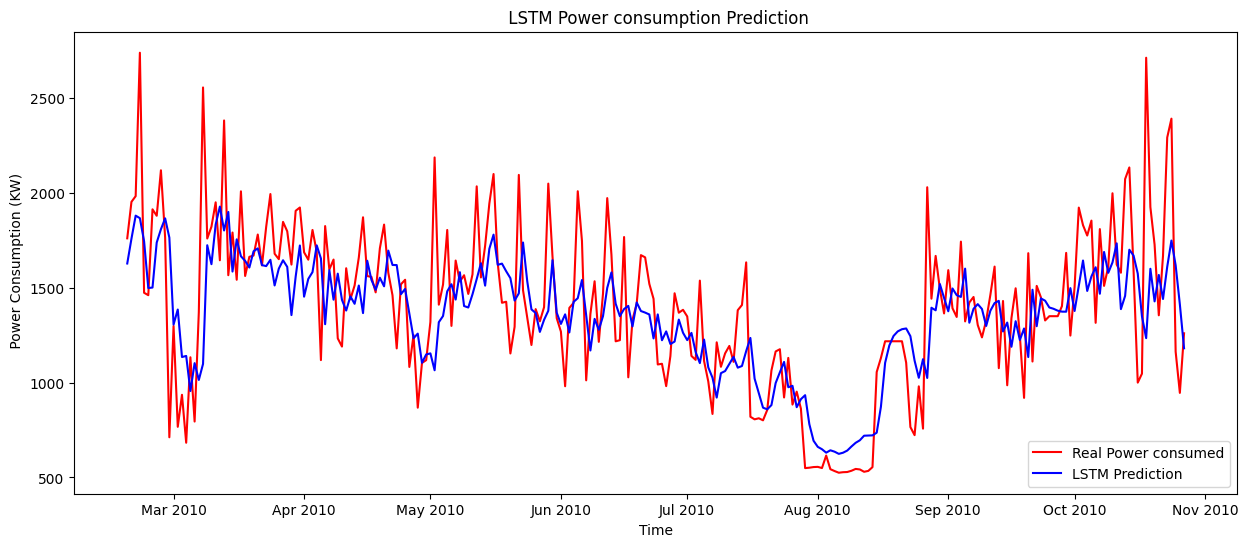

In [50]:
# Let's plot the results

df_for_testing.index = pd.to_datetime(df_for_testing.index)

plt.figure(figsize=(15, 6))
plt.plot(df_for_testing.index[30:], original, color = 'red', label = 'Real Power consumed')
plt.plot(df_for_testing.index[30:], pred, color = 'blue', label = 'LSTM Prediction')

plt.title(' LSTM Power consumption Prediction')
plt.xlabel('Time')
plt.ylabel(' Power Consumption (KW)')
plt.legend()

# Formating X-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))


plt.show()

Compara reseultado com o test - calculando erro

In [135]:
from sklearn.metrics import mean_absolute_error

# Let's compute the error between the prediction and the original value for the test set

mae = mean_absolute_error(original, pred)

# Mean error
print(f'Mean error: {mae}')

Mean error: 222.9311065673828


In [71]:
from sklearn.metrics import mean_squared_error

# Let's compute the RMSE between the prediction and the original value for the test set
# calculate RMSE
rmse = sqrt(mean_squared_error(original, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 308.904


In [74]:
# Now let's predict next 30 days

# We had already defined this future 30 days
df_30_days_future.shape
df_30_days_past = df.iloc[-30:,:]


In [105]:
df_30_days_future.head()

,total_real_power,reactive_power,voltage,current_intensity,kitchen,laundry_room,temp_control
datetime,,,,,,,
2010-10-28,NaN,187.240,246.25390,6048.2,66.180000,157.620000,545.22
2010-10-29,NaN,195.720,245.74310,5057.2,64.500000,43.559998,234.66
2010-10-30,NaN,195.320,243.26736,8969.8,141.180000,36.840000,918.18
2010-10-31,NaN,208.082,245.49527,6098.6,85.799995,40.680000,335.34
2010-11-01,NaN,187.086,246.37961,5670.2,0.000000,38.040000,524.76


In [76]:
# Scale the past 30 days and the parameters for the next 30 days

old_scaled_array=scaler.transform(df_30_days_past)
new_scaled_array=scaler.transform(df_30_days_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)


In [77]:
full_df.shape

(60, 7)

In [78]:
full_df_scaled_array=full_df.values

In [101]:
all_data = []
time_step = 30
for i in range(time_step, len(full_df_scaled_array)):
    data_x = []
    data_x.append(full_df_scaled_array[i-time_step: i, 0:full_df_scaled_array.shape[1]])
    data_x = np.array(data_x, dtype=np.float32)
    prediction = my_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i, 0] = prediction

1/1 [==============================] - 0s 19ms/step


In [102]:
# Reverse the scale for predictions
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,7, axis=-1)
y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),7)))[:,0]

In [103]:
y_pred_future_30_days

array([1230.9137, 1291.0735, 1255.4955, 1641.1649, 1497.3368, 1504.6749,
       1456.1731, 1458.5989, 1388.1362, 1500.5712, 1666.1799, 1641.9548,
       1723.0499, 1750.5609, 1530.9612, 1495.8998, 1583.8904, 1691.778 ,
       1673.6266, 1449.1241, 1497.5347, 1565.4298, 1634.9308, 1633.8165,
       1640.0848, 1424.7383, 1559.7655, 1522.863 , 1560.2686, 1524.8384],
      dtype=float32)

In [132]:
df_check = pd.read_csv('data/df_daily_future_test.csv')
df_check = df_check.set_index('datetime')

In [133]:
from sklearn.metrics import mean_squared_error

# Let's compute the RMSE and MAE between the prediction and the original value for the test set


# Mean Absolute error

#mae_array = np.abs(y_pred_future_30_days, df_check.iloc[:,0])
#mae_mean = np.mean(mae_array)
mae = mean_absolute_error(y_pred_future_30_days, df_check.iloc[:,0])
print(f'Mean absolute error: {mae}')




# calculate RMSE
rmse = sqrt(mean_squared_error(y_pred_future_30_days, df_check.iloc[:,0]))
print('Test RMSE: %.3f' % rmse)

Mean absolute error: 284.09809534505206
Test RMSE: 385.693
